In [3]:
import QUANTAXIS as QA
import sys
sys.path.append('/root/workspace/QUANTAXIS/src')
from stock_head import *
from utils import *
from model import BoostModel, XGBoostRegression
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from QUANTAXIS.QAUtil.QASetting import *
print(DEFAULT_DB_URI)
## for qlib's data
data_dir = '/root/workspace/data/'
if not os.path.exists(data_dir):
    os.mkdir(data_dir, mode=0o777)

os.environ['TZ'] = 'Asia/Shanghai'
print(time.asctime(time.localtime(time.time())))
start_date = QA.QA_util_get_next_trade_date('2010-01-01')
end_date = QA.QA_util_get_pre_trade_date(datetime.date.today().strftime("%Y-%m-%d"))
test_date = '2017-01-26' ## test dataset start on this day
## industry standard SW_l1 changed on this day
industry_change_date = QA.QA_util_get_real_date('2014-02-21')

date_dict = QA.QAUtil.QA_util_getBetweenMonth(start_date, end_date)
monthend_date = [ QA.QA_util_format_date2str(item[1]) for item in list(date_dict.values())]
real_date_list = [x.strftime('%Y-%m-%d') for x in list(pd.date_range(start=start_date, end=end_date))]
trade_date_list = trade_date_sse[trade_date_sse.index(start_date) : trade_date_sse.index(end_date)]
month_end_trade_date = [item if QA.QA_util_if_trade(item) else QA.QA_util_get_pre_trade_date(item, 1) for item in monthend_date]
# print(month_end_trade_date[-15:])

## model & period
ranks = 3 ## use for classfication
model_list = ['xgboost']
period_list = [6, 12, 36, 60]
model_period = [ i+str(j) for j in period_list for i in model_list ]

# test_date = '2019-01-31'

mongodb://localhost:27017
Thu Jul 22 13:37:45 2021


#  1.数据清理，去除停牌、ST、新股， 增加industry及weight

In [2]:
code_list = QA.QA_fetch_stock_list_adv().index.tolist()
info_df = QA.QA_fetch_stock_day_adv(code=code_list, start=start_date, end=end_date).to_qfq().resample('M').close.unstack()

## 去除停牌未交易
info_df = info_df[info_df.index.isin(month_end_trade_date)].pct_change(fill_method=None).shift(-1)
info_df.iloc[-1, :].fillna(0, inplace=True)
info_df = info_df.stack().rename('rtn').reset_index().drop_duplicates(subset=['date', 'code'])

print(info_df.shape)

(371622, 3)


In [3]:
## 做标识：ST、新股（90天之内上市）
to_drop_df = pd.DataFrame()
for date in info_df.date.unique():
    new_df = QA_fetch_new_stocks(date).assign(reason='new')
    ST_df = QA_fetch_ST_stocks(cursor_date=date).assign(reason='ST')
    to_drop_df = to_drop_df.append(new_df[['reason']]).append(ST_df[['reason']])

print(to_drop_df.shape)
## 去除以上做好标识的股票
info_df = pd.merge(info_df, to_drop_df.reset_index(), 
                   left_on=['date', 'code'], right_on=['date', 'code'], how='left')
info_df = info_df[ ~info_df['reason'].notnull() ]
print(f"info_df.shape: {info_df.shape}")

(22978, 1)
info_df.shape: (353071, 4)


In [4]:
## 读取industry信息，并增加weight. 只取sw_l1的数据
industry_df = pd.DataFrame()
for date in info_df.date.unique():
    tmp_1 = QA_fetch_industry_by_stock(date)
    if(tmp_1.empty):
        print(date)
        break
    tmp_1 = tmp_1[((tmp_1['src'] == 'sw' ) & (tmp_1['level'] == 'l1'))]    
    tmp_2 = QA_fetch_index_weights(date)[['index_code', 'weight']]  
    industry_df = industry_df.append(pd.merge(tmp_1[['industry_code']], tmp_2, 
                                              left_index=True, right_index=True, how='left'))
    
info_df = pd.merge(info_df[['date', 'code', 'rtn']], industry_df.reset_index(),
                   left_on=['date', 'code'], right_on=['date', 'code'], how='inner'
                  ).dropna(subset=['industry_code'])
# info_df = info_df[~info_df.index.duplicated(keep='first')]
info_df.shape

(352944, 6)

In [5]:
## 增加股票所占指数weight
weight_300 = info_df[info_df['index_code']=='000300'].groupby(['date', 'industry_code'])['weight'].sum().rename('industry_of_300')
weight_500 = info_df[info_df['index_code']=='000905'].groupby(['date', 'industry_code'])['weight'].sum().rename('industry_of_500')
info_df = pd.merge(info_df, weight_300, 
                   left_on=['date', 'industry_code'], right_on=['date', 'industry_code'], how='left')
info_df = pd.merge(info_df, weight_500, 
                   left_on=['date', 'industry_code'], right_on=['date', 'industry_code'], how='left')
info_df.shape

(352944, 8)

In [6]:
info_df.to_csv(data_dir+'info_df_1.csv', encoding='gbk')
info_df.tail(5)

,date,code,rtn,industry_code,index_code,weight,industry_of_300,industry_of_500
352939,2021-06-30,688777,0.0,801730,NaN,NaN,4.055,6.494
352940,2021-06-30,688788,0.0,801740,NaN,NaN,1.279,3.666
352941,2021-06-30,688819,0.0,801730,NaN,NaN,4.055,6.494
352942,2021-06-30,688981,0.0,801080,NaN,NaN,8.661,7.573
352943,2021-06-30,689009,0.0,801880,NaN,NaN,2.828,3.849


## 2. 处理factor数据

In [7]:
info_df = pd.read_csv(data_dir+'info_df_1.csv', encoding='gbk', dtype={'code':str}, index_col=0, parse_dates=['date'])
info_df = info_df[['date', 'code', 'industry_code', 'rtn']]
info_df.shape

(352944, 4)

In [8]:
## load factor from database. these data come from uqer
factor_df = QA_fetch_stock_factor(code = info_df['code'].unique().tolist())
factor_df = pd.merge(info_df[['date', 'code', 'industry_code']], factor_df, 
                     left_on=['date', 'code'], right_on=['date', 'code'], how='inner').drop_duplicates(subset=['date', 'code'])
factor_df = factor_df.drop(columns=['industry_code', 'BondsPayableToAsset', 'CTOP'])
f_cols1 = list(set(factor_df.columns.tolist()) - set(['date', 'code']))
# f_cols1 = list(set(feature_cols) - set(['BondsPayableToAsset', 'CTOP', 'CashToCurrentLiability', 'CurrentAssetsTRate', 'ROA5', 'HSIGMA', 'MLEV', 'CurrentRatio', 'CTOP', 'BLEV', 'ROE5']))
# f_cols1 = list(set(factor_df.columns.tolist()) - set(['date', 'code']) - set(['BondsPayableToAsset', 'CTOP']) )
print(factor_df.shape)

(328775, 244)


In [9]:
# ## from MS qlib's data
alpha = pd.read_csv(data_dir+'alpha.csv', dtype={"code":str}, encoding='gbk', parse_dates=['date'])
alpha = alpha.drop(columns=['VWAP0', 'LABEL0', 'MA10','MA20','MA5',  'MA60', 'VSTD10', 'VSTD20', 'ROC20'])
f_cols2 = list(set(alpha.columns.tolist()) - set(['date', 'code']))
# f_cols2 = list(set(alpha.columns.tolist()) - set(['OPEN0','HIGH0','LOW0','VWAP0','VSUMD60', 'QTLU10']))
print(alpha.shape)

(350035, 152)


In [10]:
df = pd.merge(info_df, factor_df, left_on=['date', 'code'], right_on=['date', 'code'], how='inner')
df = pd.merge(df, alpha, left_on=['date', 'code'], right_on=['date', 'code'], how='inner')
df = df.set_index(['date', 'code'])
df = df[~df.index.duplicated(keep='first')].reset_index()
# f_cols = f_cols1
f_cols = f_cols1+f_cols2
print(df.shape)

(305314, 396)


In [11]:
## fill NA with industry's mean value
to_drop = calc_NAs(df, threshold=0.05)
f_cols = list(set(f_cols) - set(to_drop) )
df = df.drop(columns = to_drop)

df = df.fillna(df.groupby(['date', 'industry_code']).transform('mean'))
df = df.groupby('code').apply(lambda x: x.fillna(method='ffill')).dropna(axis=0)
na_col = calc_NAs(df)
print(df.shape, len(f_cols))

    DAREC  DASREV   DAREV    GREC  FSALESG  FEARNG  SFY12P   FY12P  GSREV    REC
0  136289  117288  115509  108825   105199  103632  103566  102005  99118  69729
na_cols: Index(['DAREC', 'DASREV', 'DAREV', 'GREC', 'FSALESG', 'FEARNG', 'SFY12P', 'FY12P', 'GSREV', 'REC', 'GREV', 'ETP5', 'CTP5', 'DVRAT', 'DDNBT', 'MLEV', 'ROE5', 'CMRA', 'ROA5'], dtype='object')
   date  STD60  RSQR30  RSQR20  RSQR10  RSQR5  BETA60  BETA30  BETA20  BETA10
0     0      0       0       0       0      0       0       0       0       0
na_cols: Index([], dtype='object')
(304771, 377) 373


In [12]:
## drop correlation bigger than threshold
corr_col = corr_feature_detect(df[f_cols], threshold=0.95)

f_cols = list(set(f_cols)- set(corr_col))
df = df.drop(columns=corr_col)
print(df.shape, len(f_cols))

(304771, 267) 263


In [13]:
## insert market value from database
## 插入市值数据， 原数据为qfq数据，应为不复权数据。此处修改了QAAnalysis_block中的market_value方法中的market_data方法，去掉to_qfq()
# factor = df[['date', 'code', 'industry_code']].pivot_table(
#     index = 'date', columns = 'code', values = 'industry_code')
# mv_df = QA_fetch_factor_weight(factor).drop('factor', axis=1).reset_index().rename(
#     columns={'datetime':'date', 'weight':'mv'})
# stock_adj = QA_fetch_stock_adj(code=mv_df['code'].unique().tolist(), 
#                                start=month_end_trade_date[0], end=month_end_trade_date[-1]).reset_index(drop=True)

# mv_df = pd.merge(mv_df, stock_adj, left_on=['date', 'code'], right_on=['date', 'code'], how='left')
# mv_df['adj'].fillna(1, inplace=True)
# mv_df['mv'] = mv_df['mv'] / mv_df['adj']

mv_df = QA_fetch_stock_fundamental(code = info_df['code'].unique().tolist())['market_cap'].reset_index()
mv_df = mv_df.rename(columns={'market_cap': 'mv'})
df = pd.merge(df, mv_df[['date', 'code', 'mv']], left_on=['date', 'code'], right_on=['date', 'code'], how='inner').sort_index()
print(df.shape)

(304771, 268)


In [14]:
# ## 进行neutrlization
df = df.dropna(axis=0).drop_duplicates(subset=['date', 'code'], keep='first').set_index(['date', 'code'])
df[f_cols] = df.groupby('date').apply(lambda x: neutralize_factor(x, f_cols, x['mv'], x['industry_code']))
print(df.shape)

[datetime.date(2010, 1, 29)]
df[cols].shape: (1362, 263), x.shape: (1362, 24)
[datetime.date(2010, 3, 31)]
df[cols].shape: (1381, 263), x.shape: (1381, 24)
[datetime.date(2010, 4, 30)]
df[cols].shape: (1402, 263), x.shape: (1402, 24)
[datetime.date(2010, 5, 31)]
df[cols].shape: (1420, 263), x.shape: (1420, 24)
[datetime.date(2010, 6, 30)]
df[cols].shape: (1463, 263), x.shape: (1463, 24)
[datetime.date(2010, 7, 30)]
df[cols].shape: (1505, 263), x.shape: (1505, 24)
[datetime.date(2010, 8, 31)]
df[cols].shape: (1542, 263), x.shape: (1542, 24)
[datetime.date(2010, 9, 30)]
df[cols].shape: (1574, 263), x.shape: (1574, 24)
[datetime.date(2010, 10, 29)]
df[cols].shape: (1592, 263), x.shape: (1592, 24)
[datetime.date(2010, 11, 30)]
df[cols].shape: (1611, 263), x.shape: (1611, 24)
[datetime.date(2010, 12, 31)]
df[cols].shape: (1632, 263), x.shape: (1632, 24)
[datetime.date(2011, 1, 31)]
df[cols].shape: (1633, 263), x.shape: (1633, 24)
[datetime.date(2011, 2, 28)]
df[cols].shape: (1645, 263), x.s

In [15]:
## parse extreme point and restrict data range
df = df.reset_index().set_index(['date', 'code','industry_code']).groupby(['date', 'industry_code']).apply(
    lambda x : filter_extreme_MAD(x)).reset_index()
print(df.shape)

(304771, 268)


In [16]:
## standardization
df = df.set_index(['date', 'code'])
df[f_cols] = df[f_cols].groupby('date').apply(lambda x : QA_standardize_factor(x.unstack()))
print(df.shape)

(304771, 266)


In [17]:
## label for classfication
df = df.reset_index(drop=False).groupby('date').apply(lambda x: label_data_by_n(x, 'rtn', ranks, drop=False))
df = df.reset_index(drop=True).sort_values(by=['date', 'code'])
df['label'] = 0
df.loc[df['label_3']==0, 'label'] = -1
df.loc[df['label_3']==2, 'label'] = 1
df['label_01'] = None
df.loc[df['label_3']==0, 'label_01'] = 0
df.loc[df['label_3']==2, 'label_01'] = 1

## rank_rtn for regression
t = df.groupby('date')['rtn'].rank(pct=True)
t -= 0.5
t *= 3.46  # NOTE: towards unit std
df['rank_rtn'] = t

In [18]:
## merged
info_df = pd.read_csv(data_dir+'info_df_1.csv', encoding='gbk', dtype={'code':str}, index_col=0, parse_dates=['date'])
info_df = info_df.drop(['rtn'], axis=1)
df = pd.merge(df, info_df, left_on=['date', 'code', 'industry_code'], 
              right_on=['date', 'code', 'industry_code'], how='left')

In [19]:
print(pd.to_datetime(df['date'].unique()).tolist()[-2:])
print(df.shape)
print(len(f_cols))

[Timestamp('2020-06-30 00:00:00'), Timestamp('2020-07-31 00:00:00')]
(304771, 276)
263


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    304771.000000
mean          0.000710
std           0.998816
min          -1.729011
25%          -0.864243
50%           0.000801
75%           0.865518
max           1.730000
Name: rank_rtn, dtype: float64

QUANTAXIS>> findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
QUANTAXIS>> findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


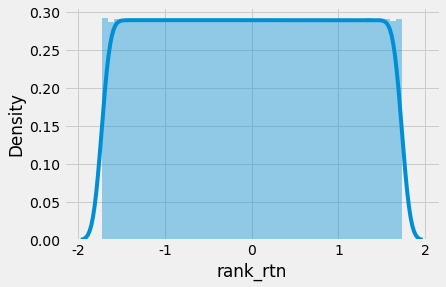

In [20]:
import seaborn as sns
sns.distplot(df['rank_rtn'])
df['rank_rtn'].describe()